In [ ]:
import numpy as np
import pandas as pd # useful for initial data handling and normalization
from sklearn.model_selection import train_test_split
from collections import Counter
import io # Library for handling uploaded file data.

def euclidean_distance_for_nn(row1, row2):
    """
    Calculates the Euclidean distance between two data points.
    Used internally by nearest_neighbor_classifier.
    """
    return np.sqrt(np.sum((row1 - row2)**2))

# A Function to load data from the specified format that is space-separated and class first
def load_data(filepath):
    """
    Loads data from a space-separated ASCII text file with the first column
    as the class label and subsequent columns as features.
    """
    data = np.loadtxt(filepath)
    # The first column is the class label, the rest are features
    classes = data[:, 0]
    features = data[:, 1:]
    return features, classes

# Nearest Neighbor Classifier: Basically it calculates Euclidean distance to find the closest training instance.
def nearest_neighbor_classifier(train_features, train_classes, test_instance):

    distances = np.array([euclidean_distance_for_nn(train_feature, test_instance) for train_feature in train_features])
    min_distance_index = np.argmin(distances)
    return train_classes[min_distance_index]

def evaluate_accuracy(features, classes, selected_features_indices):
    """
    Evaluates the accuracy of the nearest neighbor classifier using
    leave-one-out cross-validation.
    """
    num_instances = features.shape[0]
    correct_predictions = 0

    for i in range(num_instances):
        test_instance = features[i, selected_features_indices]

        # Training data excludes the current instance
        train_features = np.delete(features, i, axis=0)[:, selected_features_indices]
        train_classes = np.delete(classes, i, axis=0)

        prediction = nearest_neighbor_classifier(train_features, train_classes, test_instance)
        if prediction == classes[i]:
            correct_predictions += 1

    accuracy = correct_predictions / num_instances
    return accuracy

# Feature Normalization (Z-score)
def z_score_normalize(features_array):
    """
    Applies Z-score normalization to numerical features in a NumPy array.
    """
    normalized_features = features_array.copy()
    for col_idx in range(features_array.shape[1]):
        mean = np.mean(features_array[:, col_idx])
        std = np.std(features_array[:, col_idx])
        if std != 0: # Avoid division by zero
            normalized_features[:, col_idx] = (features_array[:, col_idx] - mean) / std
    return normalized_features

# Forward Selection Algorithm
def forward_selection(features, classes):
    """
    Implements the Forward Selection feature selection algorithm.
    Starts with an empty set of features and iteratively adds the feature
    that provides the best accuracy improvement.
    """
    num_features = features.shape[1]
    current_features = []
    best_overall_accuracy = 0.0
    best_overall_features = []

    print("\n Okay, I am beginning Forward Selection Search, get ready")
    print("  (This may take some time depending on the dataset size and number of features)")

    for _ in range(num_features):
        best_accuracy_this_step = -1.0
        feature_to_add = -1

        for i in range(num_features):
            if i not in current_features:
                temp_features = current_features + [i]
                accuracy = evaluate_accuracy(features, classes, temp_features)
                print(f"  Can Add new feature {i+1}. Current feature set: {[f+1 for f in temp_features]} Accuracy: {accuracy:.4f}")

                if accuracy > best_accuracy_this_step:
                    best_accuracy_this_step = accuracy
                    feature_to_add = i

        # Only add if there was an improvement or a feature to add found
        if feature_to_add != -1 and best_accuracy_this_step >= best_overall_accuracy: # >= to allow for plateaus but still progress
            current_features.append(feature_to_add)
            best_overall_accuracy = best_accuracy_this_step
            best_overall_features = list(current_features) # Make a copy
            print(f"  Feature {feature_to_add+1} added. Current best feature set: {[f+1 for f in current_features]} Accuracy: {best_accuracy_this_step:.4f}")
        else: # No further improvement or no feature to add
            print("  No further improvement found. Stopping Forward Selection.")
            break

    print("\nForward Selection finished.")
    print(f"Best feature set: {[f+1 for f in best_overall_features]} with accuracy: {best_overall_accuracy:.4f}")
    return best_overall_features, best_overall_accuracy

# Backward Elimination Algorithm
def backward_elimination(features, classes):
    """
    Implements the Backward Elimination feature selection algorithm.
    Starts with all features and iteratively removes the feature that
    results in the best accuracy (or least degradation).
    """
    num_features = features.shape[1]
    current_features = list(range(num_features)) # Start with all features

    # Evaluate initial accuracy with all features
    initial_accuracy = evaluate_accuracy(features, classes, current_features)
    best_overall_accuracy = initial_accuracy
    best_overall_features = list(current_features) # Initialize with all features

    print("\nBeginning Backward Elimination Search...")
    print(f"  Initial accuracy with all features ({[f+1 for f in current_features]}): {initial_accuracy:.4f}")

    while len(current_features) > 1: # Continue until only one feature remains
        temp_best_accuracy = -1.0 # Best accuracy achieved by removing one feature in this step
        feature_to_remove = -1
        temp_features_after_removal_step = []

        for i, feature_index_to_consider_removing in enumerate(current_features):
            temp_features = [f for f in current_features if f != feature_index_to_consider_removing]
            if not temp_features: # Avoid empty feature set
                continue

            accuracy = evaluate_accuracy(features, classes, temp_features)
            print(f"    Considering removing feature {feature_index_to_consider_removing+1}. Current feature set if removed: {[f+1 for f in temp_features]} Accuracy: {accuracy:.4f}")

            if accuracy > temp_best_accuracy:
                temp_best_accuracy = accuracy
                feature_to_remove = feature_index_to_consider_removing
                temp_features_after_removal_step = temp_features

        # If removing a feature improved or maintained accuracy
        if feature_to_remove != -1 and temp_best_accuracy >= best_overall_accuracy:
            current_features = temp_features_after_removal_step
            best_overall_accuracy = temp_best_accuracy
            best_overall_features = list(current_features) # Update overall best
            print(f"  Feature {feature_to_remove+1} removed. Current best feature set: {[f+1 for f in current_features]} Accuracy: {temp_best_accuracy:.4f}")
        else: # No further improvement or only one feature left
            print("  No further improvement found. Stopping Backward Elimination.")
            break

    print("\nBackward Elimination finished.")
    print(f"Best feature set: {[f+1 for f in best_overall_features]} with accuracy: {best_overall_accuracy:.4f}")
    return best_overall_features, best_overall_accuracy


if __name__ == "__main__":
    print("Rohan Tikotekar: AI Project 2: Feature Selection")
    print("RT: Please upload your dataset file to your Colab environment.")
    print("\n The expected dataset format: Space-separated ASCII text file. First column is the class label, subsequent columns are features.")

    data_filepath = input("\nEnter the filename of your dataset: ")

    features_raw = None
    classes = None

    try:
        # We load data from the specified path
        features_raw, classes = load_data(data_filepath)
        print(f"Successfully loaded dataset: {features_raw.shape[0]} instances, {features_raw.shape[1]} features.")

        # Normalize features
        features_normalized = z_score_normalize(features_raw)
        print("Features normalized (Z-score).")

        # Evaluate initial accuracy of NN with all features
        initial_accuracy_all_features = evaluate_accuracy(features_normalized, classes, list(range(features_normalized.shape[1])))
        print(f"Initial Nearest Neighbor accuracy with all features: {initial_accuracy_all_features:.4f}")

        # Offer user choice of algorithm
        while True:
            print("\nChoose a feature selection algorithm:")
            print("  1. Forward Selection")
            print("  2. Backward Elimination")
            choice = input("Enter your choice (1 or 2): ")

            if choice == '1':
                print("\n--- Running Forward Selection ---")
                fs_best_features, fs_best_accuracy = forward_selection(features_normalized, classes)
                print(f"\nForward Selection Final Results:")
                print(f"  Selected Features (indices + 1): {[f+1 for f in fs_best_features]}")
                print(f"  Best Accuracy: {fs_best_accuracy:.4f}")
                break # Exit loop after execution
            elif choice == '2':
                print("\n--- Running Backward Elimination ---")
                be_best_features, be_best_accuracy = backward_elimination(features_normalized, classes)
                print(f"\nBackward Elimination Final Results:")
                print(f"  Selected Features (indices + 1): {[f+1 for f in be_best_features]}")
                print(f"  Best Accuracy: {be_best_accuracy:.4f}")
                break # Exit loop after execution
            else:
                print("Invalid choice. Please enter '1' or '2'.")

    except FileNotFoundError:
        print(f"\nError: The file '{data_filepath}' was not found.")
        print("Please ensure the file is uploaded to your Colab session or the path is correct.")
    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")
        print("Please check your dataset format and ensure it matches the expected structure.")



Rohan Tikotekar: AI Project 2: Feature Selection
RT: Please upload your dataset file to your Colab environment.

 The expected dataset format: Space-separated ASCII text file. First column is the class label, subsequent columns are features.
Successfully loaded dataset: 1000 instances, 50 features.
Features normalized (Z-score).
Initial Nearest Neighbor accuracy with all features: 0.6540

Choose a feature selection algorithm:
  1. Forward Selection
  2. Backward Elimination

--- Running Backward Elimination ---

Beginning Backward Elimination Search...
  Initial accuracy with all features ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]): 0.6540
    Considering removing feature 1. Current feature set if removed: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3

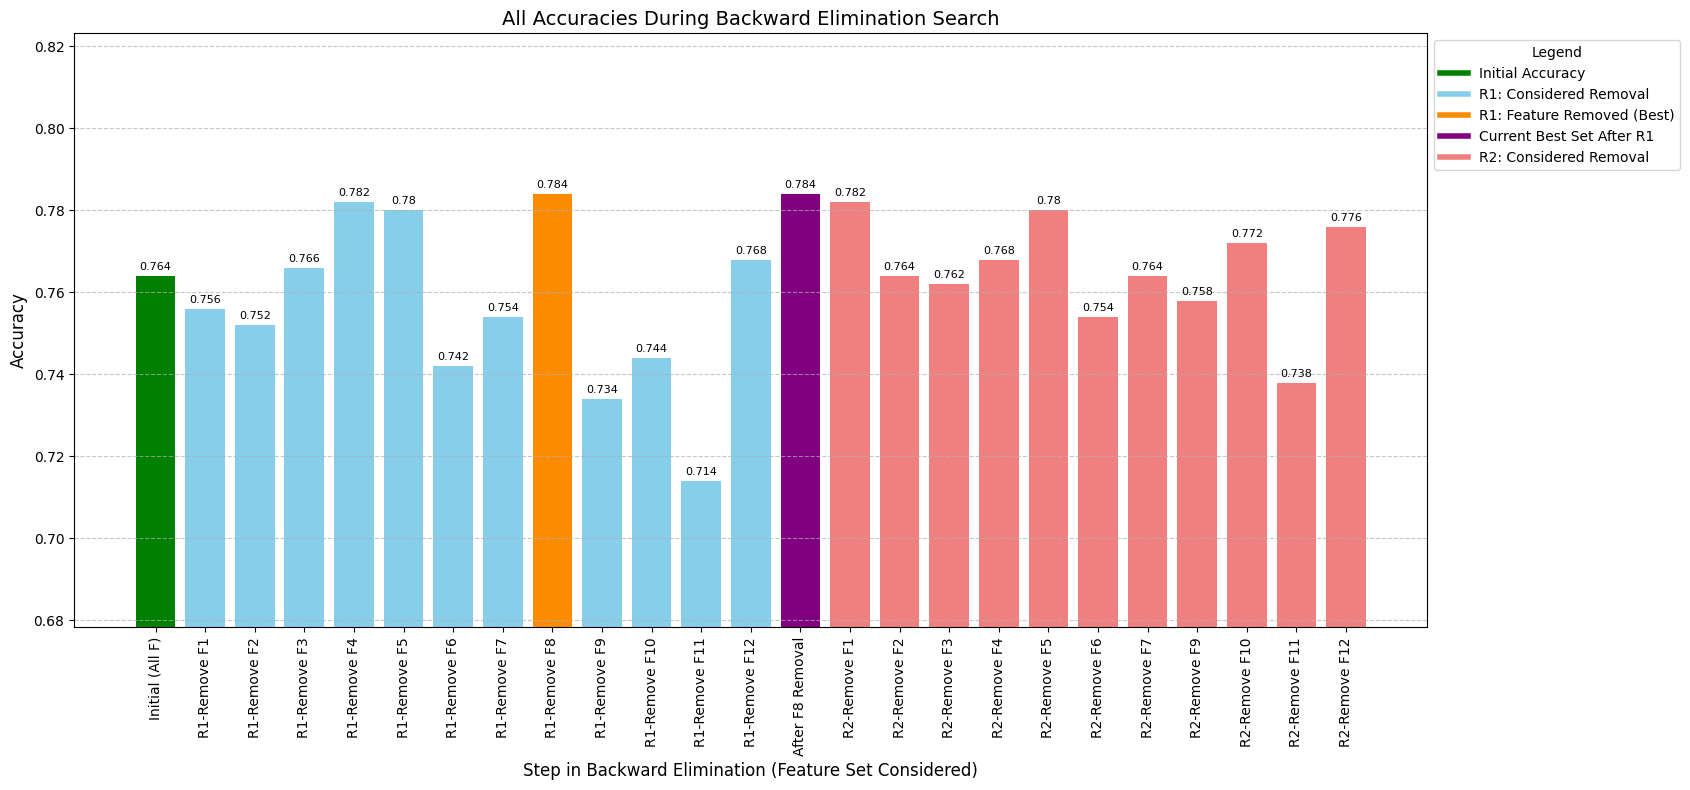

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from the provided text for Backward Elimination
# Initial accuracy with all features

initial_accuracy = 0.7640

round1_considerations = {
    'F1': 0.7560, 'F2': 0.7520, 'F3': 0.7660, 'F4': 0.7820,
    'F5': 0.7800, 'F6': 0.7420, 'F7': 0.7540, 'F8': 0.7840, # Best in round 1
    'F9': 0.7340, 'F10': 0.7440, 'F11': 0.7140, 'F12': 0.7680
}
best_accuracy_round1 = round1_considerations['F8'] # Feature 8 was actually removed

# Accuracies from the second round of considering removals (after F8 was removed)
round2_considerations = {
    'F1': 0.7820, 'F2': 0.7640, 'F3': 0.7620, 'F4': 0.7680,
    'F5': 0.7800, 'F6': 0.7540, 'F7': 0.7640, 'F9': 0.7580,
    'F10': 0.7720, 'F11': 0.7380, 'F12': 0.7760
}
# In the second round, no improvement was found, so the best is still best_accuracy_round1

# Prepare data for plotting
labels = ['Initial (All F)']
values = [initial_accuracy]
colors = ['green'] # Color for initial accuracy

# Add data for Round 1 considerations
for feature, accuracy in round1_considerations.items():
    labels.append(f'R1-Remove {feature}')
    values.append(accuracy)
    if feature == 'F8': # Highlight the feature that was actually removed
        colors.append('darkorange')
    else:
        colors.append('skyblue')

# Add the state after Round 1 (best feature set after removal)
labels.append('After F8 Removal')
values.append(best_accuracy_round1)
colors.append('purple') # Color for the new current best set

# Add data for Round 2 considerations
# Note: Feature F8 is no longer in the set, so it won't appear in R2 considerations.
for feature, accuracy in round2_considerations.items():
    labels.append(f'R2-Remove {feature}')
    values.append(accuracy)
    colors.append('lightcoral') # Different color for second round considerations

# Create the bar chart
plt.figure(figsize=(20, 8)) # Make the figure wider to accommodate many bars
bars = plt.bar(labels, values, color=colors)

# Add labels and title
plt.xlabel('Step in Backward Elimination (Feature Set Considered)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('All Accuracies During Backward Elimination Search', fontsize=14)

# Set y-axis limits to better visualize accuracy values
plt.ylim(min(values) * 0.95, max(values) * 1.05) # Auto-adjust limits based on data range

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels for readability, adjust font size if needed
plt.xticks(rotation=90, ha='center', fontsize=10) # 'ha' set to center for better alignment after rotation

# Add accuracy values on top of the bars for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, round(yval, 4), ha='center', va='bottom', fontsize=8)

# Add a legend
legend_elements = [
    plt.Line2D([0], [0], color='green', lw=4, label='Initial Accuracy'),
    plt.Line2D([0], [0], color='skyblue', lw=4, label='R1: Considered Removal'),
    plt.Line2D([0], [0], color='darkorange', lw=4, label='R1: Feature Removed (Best)'),
    plt.Line2D([0], [0], color='purple', lw=4, label='Current Best Set After R1'),
    plt.Line2D([0], [0], color='lightcoral', lw=4, label='R2: Considered Removal')
]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), title="Legend")

plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make room for the legend

# Show the plot
plt.show()

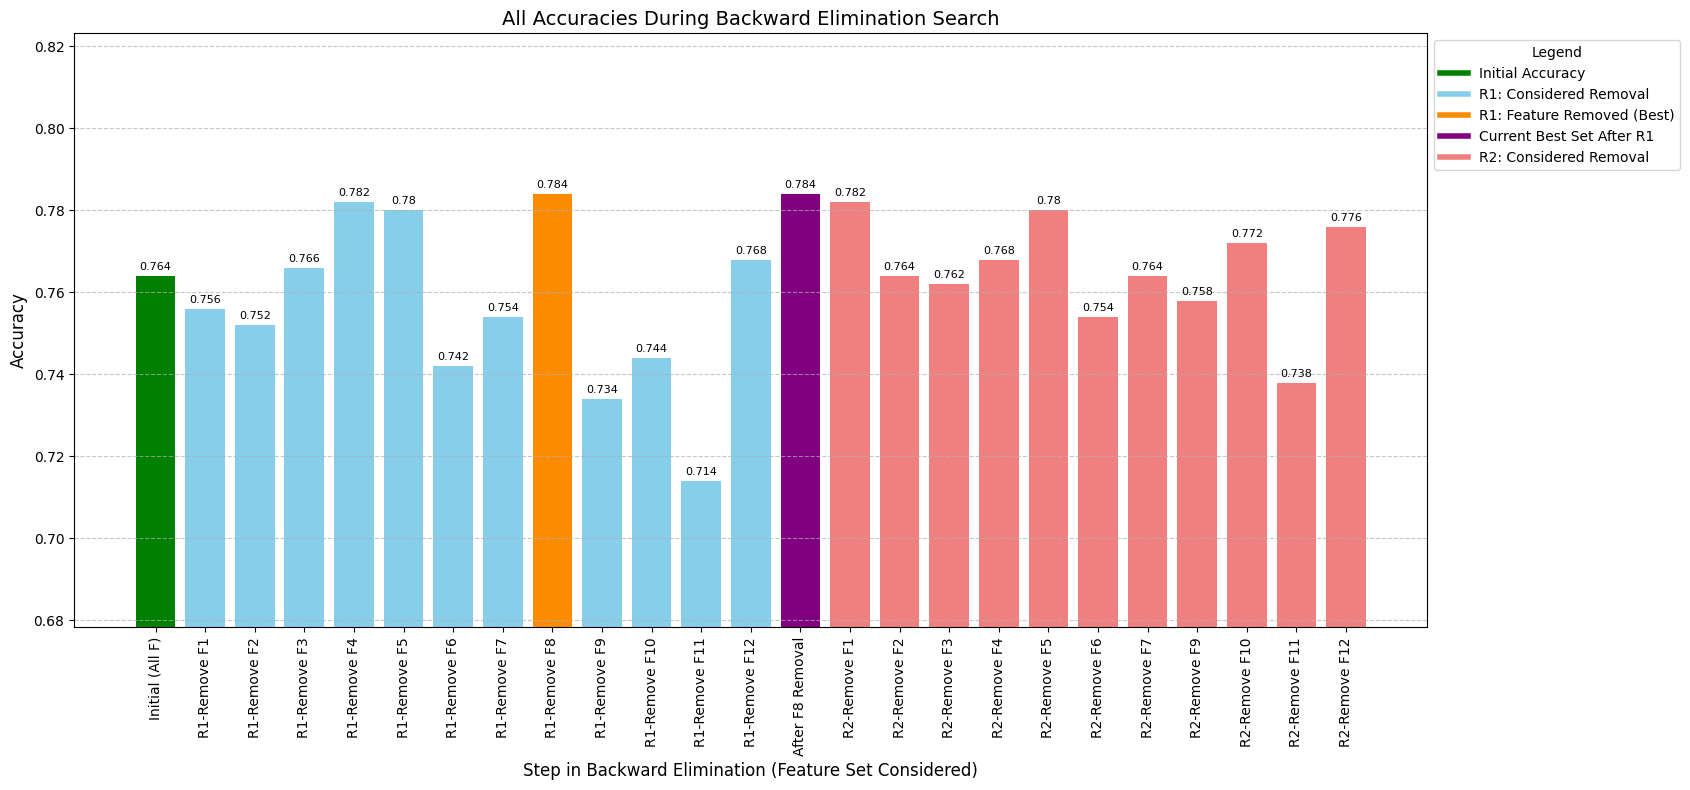

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from the provided text for Backward Elimination
# Initial accuracy with all features
initial_accuracy = 0.7640

# Accuracies from the first round of considering removals
# Key: Feature to remove, Value: Accuracy if that feature is removed
round1_considerations = {
    'F1': 0.7560, 'F2': 0.7520, 'F3': 0.7660, 'F4': 0.7820,
    'F5': 0.7800, 'F6': 0.7420, 'F7': 0.7540, 'F8': 0.7840, # Best in round 1
    'F9': 0.7340, 'F10': 0.7440, 'F11': 0.7140, 'F12': 0.7680
}
best_accuracy_round1 = round1_considerations['F8'] # Feature 8 was actually removed

# Accuracies from the second round of considering removals (after F8 was removed)
round2_considerations = {
    'F1': 0.7820, 'F2': 0.7640, 'F3': 0.7620, 'F4': 0.7680,
    'F5': 0.7800, 'F6': 0.7540, 'F7': 0.7640, 'F9': 0.7580,
    'F10': 0.7720, 'F11': 0.7380, 'F12': 0.7760
}
# In the second round, no improvement was found, so the best is still best_accuracy_round1

# Prepare data for plotting
labels = ['Initial (All F)']
values = [initial_accuracy]
colors = ['green'] # Color for initial accuracy

# Add data for Round 1 considerations
for feature, accuracy in round1_considerations.items():
    labels.append(f'R1-Remove {feature}')
    values.append(accuracy)
    if feature == 'F8': # Highlight the feature that was actually removed
        colors.append('darkorange')
    else:
        colors.append('skyblue')

# Add the state after Round 1 (best feature set after removal)
labels.append('After F8 Removal')
values.append(best_accuracy_round1)
colors.append('purple') # Color for the new current best set

# Add data for Round 2 considerations
# Note: Feature F8 is no longer in the set, so it won't appear in R2 considerations.
for feature, accuracy in round2_considerations.items():
    labels.append(f'R2-Remove {feature}')
    values.append(accuracy)
    colors.append('lightcoral') # Different color for second round considerations

# Create the bar chart
plt.figure(figsize=(20, 8)) # Make the figure wider to accommodate many bars
bars = plt.bar(labels, values, color=colors)

# Add labels and title
plt.xlabel('Step in Backward Elimination (Feature Set Considered)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('All Accuracies During Backward Elimination Search', fontsize=14)

# Set y-axis limits to better visualize accuracy values
plt.ylim(min(values) * 0.95, max(values) * 1.05) # Auto-adjust limits based on data range

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels for readability, adjust font size if needed
plt.xticks(rotation=90, ha='center', fontsize=10) # 'ha' set to center for better alignment after rotation

# Add accuracy values on top of the bars for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, round(yval, 4), ha='center', va='bottom', fontsize=8)

# Add a legend
legend_elements = [
    plt.Line2D([0], [0], color='green', lw=4, label='Initial Accuracy'),
    plt.Line2D([0], [0], color='skyblue', lw=4, label='R1: Considered Removal'),
    plt.Line2D([0], [0], color='darkorange', lw=4, label='R1: Feature Removed (Best)'),
    plt.Line2D([0], [0], color='purple', lw=4, label='Current Best Set After R1'),
    plt.Line2D([0], [0], color='lightcoral', lw=4, label='R2: Considered Removal')
]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), title="Legend")

plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make room for the legend

# Show the plot
plt.show()

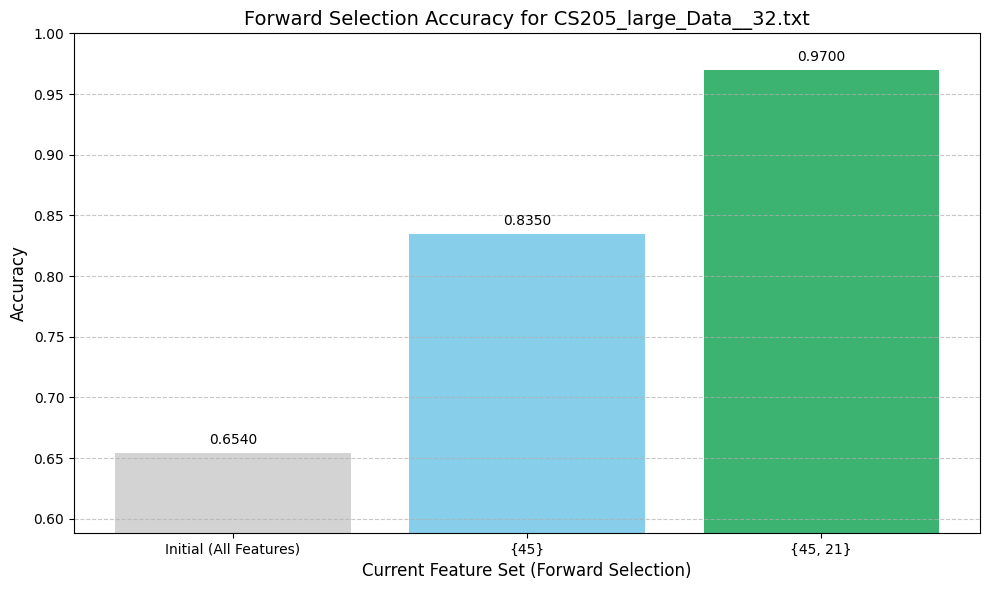

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from the provided Forward Selection output for CS205_large_Data__32.txt
initial_accuracy = 0.6540

# Accuracies at each step where the best feature set was updated
step1_accuracy = 0.8350  # After adding feature 45, current best set: [45]
step2_accuracy = 0.9700  # After adding feature 21, current best set: [45, 21]

# Prepare data for plotting
labels = ['Initial (All Features)', '{45}', '{45, 21}']
values = [initial_accuracy, step1_accuracy, step2_accuracy]

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['lightgray', 'skyblue', 'mediumseagreen'])

# Add labels and title
plt.xlabel('Current Feature Set (Forward Selection)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Forward Selection Accuracy for CS205_large_Data__32.txt', fontsize=14)

# Set y-axis limits to better visualize accuracy values
plt.ylim(min(values) * 0.9, 1.0) # Adjust limits to show the relevant range of accuracies

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add accuracy values on top of the bars for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.4f}", ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()